In [1]:
import pygame
import numpy as np
import sys
import matplotlib.pyplot as plt

pygame 2.4.0 (SDL 2.26.4, Python 3.8.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
def create_maze(dim, num_of_walls):
    # Define the maze
    maze = np.zeros((dim,dim))

    #Select random walls
    for i in range(num_of_walls):
        a,b = np.random.random_integers(1,dim-2,2)
        maze[a,b] = 1

    # Define the goal state
    maze[dim-1, dim-1] = 2
    goal_state = (dim-1, dim-1)
    return maze, goal_state

In [3]:
# Define the actions and their corresponding changes in position
actions = ['up', 'down', 'left', 'right']
action_deltas = [(-1, 0), (1, 0), (0, -1), (0, 1)]

In [4]:
# Define the rewards for each state
rewards = {
    0: -1,   # Maze cell
    1: -2,   # Wall
    2: 10    # Goal
}

In [5]:
# Define a function to choose an action using the epsilon-greedy policy
def choose_action(state, epsilon):
    if np.random.random() < epsilon:
        # Choose a random action
        return actions[np.random.randint(0, len(actions))]
    else:
        # Choose the action with the highest Q-value
        return actions[np.argmax(Q[state[0], state[1]])]

In [31]:
def update_q_value_n_step(state_n, action_n, G, alpha):
    old_q_value = Q[state_n[0], state_n[1], actions.index(action_n)]
    new_q_value = old_q_value + alpha * (G - old_q_value)
    Q[state_n[0], state_n[1], actions.index(action_n)] = new_q_value

In [32]:
def calculate_n_step_return(transitions, gamma, n_steps):
    n = len(transitions)
    G = 0

    for i in range(n):
        if i + n_steps < n:
            G += transitions[i][2] * (gamma ** i)
        else:
            G += transitions[i][2] * (gamma ** i)

    if n >= n_steps:
        G += (gamma ** n_steps) * transitions[n_steps - 1][2]

    return G

In [33]:
#Define the colors to use
BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255)
YELLOW = (255,255,0)

In [39]:
# Define a function to simulate an episode for n-td learning method
def run_episode_n_td(alpha, gamma, epsilon, n_steps, training=True):
    
    # Choose a random starting state that is not the goal state
    state = (np.random.randint(0, maze.shape[0]), np.random.randint(0, maze.shape[1]))

    while state == goal_state:
        state = (np.random.randint(0, maze.shape[0]), np.random.randint(0, maze.shape[1]))
    
    init = state
    
    if training == False:
        # Clear the screen
        screen.fill(WHITE)

        # Draw the maze and the goal
        for i in range(maze.shape[0]):
            for j in range(maze.shape[1]):
                rect = pygame.Rect(j*cell_size, i*cell_size, cell_size, cell_size)
                if i == init[0] and j == init[1]: #Start cell
                    pygame.draw.rect(screen, YELLOW, rect)
                    pygame.draw.circle(screen, RED, (state[1]*cell_size+25,state[0]*cell_size+25), 5)
                elif maze[i,j] == 0:  # Maze cell
                    pygame.draw.rect(screen, BLACK, rect)
                elif maze[i,j] == 1:  #Wall
                    pygame.draw.rect(screen, BLUE, rect)
                elif maze[i,j] == 2: #Goal
                    pygame.draw.rect(screen, GREEN, rect)
    
    # Choose the first action using an epsilon-greedy policy
    action = choose_action(state, epsilon)
    
    # Initialize the total reward
    episode_reward = 0
    done = False
    
    # Initialize a list to store the n-step transitions
    transitions = []
    
    while state != goal_state:
        # Move to the next state
        delta = action_deltas[actions.index(action)]
        next_state = (state[0]+delta[0], state[1]+delta[1])
        
        # If the next state is outside the maze, set it to the current state
        if next_state[0] < 0 or next_state[0] >= maze.shape[0] or next_state[1] < 0 or next_state[1] >= maze.shape[1]:
            next_state = state
            # Update reward as the action taken hit the border of the wall
            episode_reward += rewards[1]
        
        # Get the reward for the next state
        reward = rewards[maze[next_state[0], next_state[1]]]
        
        next_action = choose_action(next_state, epsilon)

        # Store the transition in the list
        transitions.append((state, action, reward))

        # Perform n-step updates
        if len(transitions) >= n_steps:
            G = calculate_n_step_return(transitions, gamma, n_steps)

            # Get the state and action n steps ago
            state_n, action_n, _ = transitions.pop(0)
            # Update the Q-value for the state-action pair
            update_q_value_n_step(state_n, action_n, G, alpha)
        
        # Update the episode reward
        episode_reward += reward
        state = next_state
        action = next_action
        
        if training == False:
            # Draw the current state of the agent
            for i in range(maze.shape[0]):
                for j in range(maze.shape[1]):
                    if i == state[0] and j == state[1]: #Next cell
                        pygame.draw.circle(screen, RED, (state[1]*cell_size+25,state[0]*cell_size+25), 5)

    # Perform remaining n-step updates for incomplete episodes
    while len(transitions) > 0:
        G = sum(reward * (gamma ** i) for i, (_, _, reward) in enumerate(transitions))
        state_n, action_n, _ = transitions.pop(0)
        update_q_value_n_step(state_n, action_n, G, alpha)

    return episode_reward

In [40]:
# Train the agent for the specified number of episodes
alpha = 0.5
gamma = 0.9
epsilon = 0.2

# Create Maze
maze, goal_state = create_maze(dim=5, num_of_walls=10)

# Initialize the Q-matrix with zeros
Q = np.zeros((maze.shape[0], maze.shape[1], 4))

for i in range(100):
    total_reward = run_episode_n_td(alpha, gamma, epsilon, 3)
    
    # Print the total reward for the episode
    print(f"Episode {i+1}: Total Reward = {total_reward}")

Episode 1: Total Reward = -499
Episode 2: Total Reward = 5
Episode 3: Total Reward = 10
Episode 4: Total Reward = -36
Episode 5: Total Reward = -43
Episode 6: Total Reward = 1
Episode 7: Total Reward = -8
Episode 8: Total Reward = -134
Episode 9: Total Reward = -226
Episode 10: Total Reward = 8
Episode 11: Total Reward = 1
Episode 12: Total Reward = -78
Episode 13: Total Reward = -7
Episode 14: Total Reward = -54
Episode 15: Total Reward = -129
Episode 16: Total Reward = 4
Episode 17: Total Reward = -100
Episode 18: Total Reward = -56
Episode 19: Total Reward = -29
Episode 20: Total Reward = -45
Episode 21: Total Reward = 0
Episode 22: Total Reward = 9
Episode 23: Total Reward = 7
Episode 24: Total Reward = 7
Episode 25: Total Reward = 3
Episode 26: Total Reward = 7
Episode 27: Total Reward = -65
Episode 28: Total Reward = -23
Episode 29: Total Reward = -133
Episode 30: Total Reward = 7
Episode 31: Total Reward = -17
Episode 32: Total Reward = -15
Episode 33: Total Reward = -11
Episode

<ipython-input-2-bea743fbf7ae>:7: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  a,b = np.random.random_integers(1,dim-2,2)


In [41]:
#Initialize Pygame
pygame.init()

#Define the size of each cell in the maze and the size of the window
cell_size = 50
window_size = (maze.shape[1]*cell_size, maze.shape[0]*cell_size)

#Create the window
screen = pygame.display.set_mode(window_size)
pygame.display.set_caption("Maze")
clock = pygame.time.Clock()

# Test the agent for the specified number of episodes
for i in range(10):
    total_reward = run_episode_n_td(alpha, gamma, epsilon, 3, training=False)
    
    # Print the total reward for the episode
    print(f"Episode {i+1}: Total Reward = {total_reward}")
    
    # Update the Pygame window
    pygame.display.flip()
    
    # Pause briefly to allow the user to see the visualization
    pygame.time.wait(3000)

# Wait for the user to close the Pygame window
while True:
    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            pygame.quit()
            sys.exit()

Episode 1: Total Reward = 5
Episode 2: Total Reward = 6
Episode 3: Total Reward = 9
Episode 4: Total Reward = -36
Episode 5: Total Reward = -50
Episode 6: Total Reward = 7
Episode 7: Total Reward = -78
Episode 8: Total Reward = -12
Episode 9: Total Reward = -2734
Episode 10: Total Reward = -22


SystemExit: 

<ipython-input-2-bea743fbf7ae>:7: DeprecationWarning: This function is deprecated. Please call randint(1, 3 + 1) instead
  a,b = np.random.random_integers(1,dim-2,2)


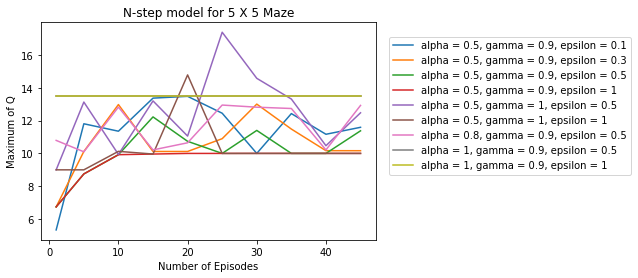

In [47]:
#For 5X5 maze

maze, goal_state = create_maze(5,10)

num_of_episodes = np.arange(0,50,5)
num_of_episodes[0] = 1
max_Q = np.zeros(len(num_of_episodes), dtype=float)

alpha = [0.5,0.5,0.5,0.5,0.5,0.5,0.8,1,1]
gamma = [0.9,0.9,0.9,0.9,1,1,0.9,0.9,0.9]
epsilon = [0.1,0.3,0.5,1,0.5,1,0.5,0.5,1]

plt.figure()
for m in range(len(alpha)):
    for i in range(len(num_of_episodes)):
        # Initialize the Q-matrix with zeros
        Q = np.zeros((maze.shape[0], maze.shape[1], 4))

        # Train the agent for the specified number of episodes
        for j in range(num_of_episodes[i]):
            _ = run_episode_n_td(alpha[m], gamma[m], epsilon[m], 3, training=True)

        #Get maximum value of Q
        max_Q[i] = Q.max()
    plt.plot(num_of_episodes, max_Q, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]))

plt.legend(loc=(1.04,0.3))
plt.title('N-step model for 5 X 5 Maze')
plt.xlabel('Number of Episodes')
plt.ylabel('Maximum of Q')
plt.show()

In [49]:
#For 10X10 maze
dim=10
maze, goal_state = create_maze(dim,15)
num_of_episodes = np.arange(0,30,5)
num_of_episodes[0] = 1
max_Q = np.zeros(len(num_of_episodes), dtype=float)

alpha = [0.5,0.5,0.5,0.5,0.5,0.5,0.8,1,1]
gamma = [0.9,0.9,0.9,0.9,1,1,0.9,0.9,0.9]
epsilon = [0.1,0.3,0.5,1,0.5,1,0.5,0.5,1]

plt.figure()
for m in range(len(alpha)):
    for i in range(len(num_of_episodes)):
        # Initialize the Q-matrix with zeros
        Q = np.zeros((maze.shape[0], maze.shape[1], 4))

        # Train the agent for the specified number of episodes
        for j in range(num_of_episodes[i]):
            _ = run_episode_n_td(alpha[m], gamma[m], epsilon[m], 3, training=True)

        #Get maximum value of Q
        max_Q[i] = Q.max()
    plt.plot(num_of_episodes, max_Q, label = 'alpha = {}, gamma = {}, epsilon = {}'.format(alpha[m], gamma[m], epsilon[m]))

plt.legend(loc=(1.04,0.3))
plt.title('N-step model for 10 X 10 Maze')
plt.xlabel('Number of Episodes')
plt.ylabel('Maximum of Q')
plt.show()

<ipython-input-2-bea743fbf7ae>:7: DeprecationWarning: This function is deprecated. Please call randint(1, 8 + 1) instead
  a,b = np.random.random_integers(1,dim-2,2)


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>